In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import yscale
from scipy import signal

# Am Anfang wird immer in Bursts übertragen, ohne Kontinuierliches Senden

# IQ Sampling

Ziel dieses Notebooks ist es, ein Verständnis für die generierung und Abtastung von IQ-Samples zu entwickeln. Dabei soll Rauschen und der Einfluss des Kanals zunächst vernachlässigt werden. Der Fokus soll hier allein auf dem Verständnis liegen, wie IQ Samples von einem SDR versendet werden, als reales Signal übertragen werden und wie sie empfangen werden.

Am Ende des Notebooks sollte folgendes klar sein:

- Was sind IQ-Samples?
- Das Sendesignal wird immer komplex beschrieben. Übertragen wird jedoch nur der Realteil. Warum?
- Wie werden aus dem realen, analogen Empfangssignal die komplexen IQ-Samples gewonnen?
- Warum können der I- und Q-Teil überlagert ausgesendet werden und dennoch beim Empfänger getrennt werden?

## Theoretischer Background: TX und RX

### Transmitter

Der Transmitter (TX) erzeugt ein diskretes komplexes Basisband-Signal $s_{\text{NF}}[n]$, welches in der Regel als I/Q-Signal bezeichnet wird. Das I/Q-Signal besteht aus zwei Komponenten: der In-Phase-Komponente (I) und der Quadratur-Komponente (Q). Das I/Q-Signal $s_{\text{NF}}[n]$ wird dann auf eine Trägerfrequenz $f_{\text{c}}$ hochgemischt und als analoges Passband Signal $s_{\text{HF}}(t)$ übertragen.



$$s_{\text{NF}}[n] = I[n] + j \text{ } Q[n]$$

* $I[n]$ ist die In-Phase-Komponente (Kosinus Anteil, Realteil)
* $Q[n]$ ist die Quadratur-Komponente (Sinus Anteil, Imaginärteil)
* Bsp.: QPSK-Sample
$$
\begin{align*}
s_{\text{QPSK}} &= 1 + j \\
                &= \sqrt{2} \text{ } e^{j\frac{\pi}{4}} \\
                &=  \sqrt{2} \cos(\frac{\pi}{4}) + j \sqrt{2}  \sin(\frac{\pi}{4}) \\
                &= I + j Q
                &= \sqrt{2} \left(\frac{\sqrt{2}}{2} + j \frac{\sqrt{2}}{2}\right) \\
                &= 1 + j
\end{align*}
$$

![IQ Sampling Receiver](./images/IQ_diagram_sender.png)

Werden die IQ-Samples vom ausgesendet, werden sie als reales Signal übertragen.

$$
                        s(t) = I(t) + j \text{ } Q(t) \text{ } e^{j 2 \pi f_{\text{c}} t} = I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t)
$$

Im SDR wird das wie im Blockschaltbild folgendermaßen realisiert:
Es wird ein Sinus generiert, welcher auf die Trägerfrequenz $f_{\text{c}}$ gemischt wird. Dieser wird dann zum einen mit der Imaginären Komponente (Q-Komponente) multipliziert. Und zum anderen wird auf ihn eine Phaseshift von 90° angewendet, das Vorzeichen umgekehrt und mit der realen Komponente (I-Komponente) multipliziert. Die beiden Signale werden dann addiert und ergeben das Sendesignal.

Bemerkung Orthogonalität: Die beiden Signale sind orthogonal zueinander, d.h. das Skalarprodukt ist 0. Das bedeutet, dass die beiden Signale unabhängig voneinander sind und der Empfänger die I und Q Komponenten aus der Summe extrahieren kann.
$$
    s_{\text{HF}}(t) = I(t) \cos(2 \pi f_{\text{c}} t) + Q(t) \sin(2 \pi f_{\text{c}} t)
$$

In [2]:
def generate_m_sequence_16bit():
    """
    Generiert eine 16 Bit lange M-Sequenz mit LFSR (Linear Feedback Shift Register)
    Verwendetes primitives Polynom: x^4 + x^3 + 1 (Taps an Position 3 und 4)
    """
    register = [1, 1, 1, 1]  # Initialzustand (darf nicht alle 0 sein)
    sequence = []

    for _ in range(16):
        # Feedback-Berechnung (XOR der Taps)
        feedback = register[3] ^ register[2]  # 0-indizierte Positionen
        sequence.append(register.pop())
        register.insert(0, feedback)

    return sequence


def normalize_energy(signal):
    energy = np.sum(np.abs(signal) ** 2)
    return signal / np.sqrt(energy)


## Generierung des Sendesignals

Das Sendesignal wird aus den Datenbits und einer Synchronisationssequenz generiert. Die Synchronisationssequenz wird verwendet, um den Empfänger zu synchronisieren. Das Sendesignal wird dann mit einem Raised-Cosine Filter gepulst, um die Bandbreite des Signals zu begrenzen.

### Konvertierung der Datenbits $\vec{b}[i]$ in BPSK Samples

   $$
    \text{BPSK}(i) = \vec{b}[i] \cdot 2 - 1
   $$

Es sollen T = 8 Samples pro Symbol verwendet werden. Das Sendesignal wird dann wie folgt generiert:

$$
    x_{\text{NF, no shape}}[n] = \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(n - i T\right)
$$

Für IQ-Modulation wird das für den I und Q Teil getrennt durchgeführt, somit ergibt sich:

$$
    x_{\text{I, no shape}}[n] = \Re\left\{x_{\text{NF, no shape}}[n]\right\}
$$
$$
    x_{\text{Q, no shape}}[n] = \Im\left\{x_{\text{NF, no shape}}[n]\right\}
$$

Im Falle von BPSK bleibt der Imaginärteil immer 0, da die BPSK Symbole nur auf der Realachse liegen, sodass hier nur $x_{\text{I, no shape}}[n]$ betrachtet wird.

## Generierung der Bits $\vec{b}[i]$

#### Aufgabe:
- Erstellen Sie ein beliebige Datenbits in `data_bits`

In [3]:
data_bits = np.array([0,0,1,1,1])

#### Aufgabe:
- Erstellen Sie im Binären Format eine Synchronisationssequenz in `synchronization_sequence`
- Hinweis: Sie können auch die obige Funktion `generate_m_sequence_16bit()` verwenden

In [4]:
synchronization_sequence = generate_m_sequence_16bit()

#### Aufgabe:
- Konkatenieren Sie die Synchronisationssequenz mit den Datenbits
- Die Konkatenation führt zu $\vec{b}[i]$ und soll in `bits` definiert werden

In [5]:
bits = np.concatenate((synchronization_sequence, data_bits))
bits

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1])

### Mapping der Bits $\vec{b}[i]$ auf BPSK Modulationssymbole

- Ziel: NumPy Array mit den Modulationssymbolen
- Jedes Bit $\vec{b}[i]$ wird auf ein BPSK Modulationssymbol gemappt
- Anweisung: Überlegen Sie sich, wie Sie die Bits auf die BPSK-Modulationssymbole mappen

#### Aufgabe:
- Erstellen Sie ein Array `BPSK`, welches die gemappten bits $\vec{b}[i]$ enthält

In [6]:
BPSK = 2 * bits - 1

### Design Basisbandpulse $h_{\text{Pulse Form}}[n]$

In [7]:
def get_raised_cosine_pulse(num_taps=101, roll_off=0.35, samples_per_symbol=8):
    Ts = samples_per_symbol # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
    t = np.arange(num_taps) - (num_taps-1)//2
    h = np.sinc(t/Ts) * np.cos(np.pi*roll_off*t/Ts) / (1 - (2*roll_off*t/Ts)**2)
    return h

def get_rect_pulse(num_taps=101, samples_per_symbol=8):
    h = np.zeros(num_taps)
    h[num_taps//2-samples_per_symbol//2:num_taps//2+samples_per_symbol//2] = 1
    return h

#### Aufgabe:
- Machen Sie sich mit den nachfolgenden Parametern vertraut, diese werden nachfolgend immer wieder verwendet und spielen eine wichtige Rolle für die korrekte Auflösung der Signale
- Befolgen Sie die Anweisungen in den Kommentaren (Sie können die Parameter auch selbst sinnvoll frei wählen).

In [59]:
# Basisband Puls soll eine Dauer T_s von 0.5 Sekunden haben
T_s = 1/2 # in seconds

# Der Puls soll 16 samples lang sein
sps = 16

# Dauer eines Samples entspricht T_s / sps
T_sample = T_s / sps

# num_tabs gibt die Gesamtlänge des Basisband Pulses an, muss natürlich länger sein als die Länge des Pulses sps. sps=101 wäre eine gute Zahl.
num_taps = 101

#### Aufgabe:
- Erstellen Sie einen Basisband Pulse $h_{\text{Pulse Form}}[n]$
- Verwenden Sie dazu eine der oben bereits definierten Funktionen:
    - `get_rect_pulse`
    - `get_raised_cosine_pulse`
- Empfehlung: Beginnen Sie mit einem  $h_{\text{Pulse Form}}[n] = \text{rect}[n]$, so können Sie später die Unterschiede bei Verwendung eines *Raised Cosine Pulses* besser erkennen.

In [60]:
h_pulse_form = get_rect_pulse(num_taps=num_taps, samples_per_symbol=sps)
t = np.arange(len(h_pulse_form)) * T_sample - len(h_pulse_form)//2 * T_sample

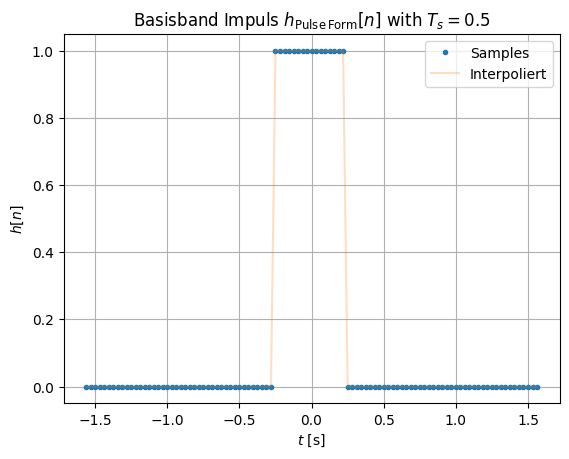

In [61]:
plt.figure(1)
plt.plot(t, h_pulse_form, '.')
plt.plot(t, h_pulse_form, '-', alpha=0.25)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$h[n]$')
plt.title(r"Basisband Impuls $h_{\mathrm{Pulse\,Form}}[n]$ with $T_s = $" + f"{T_s}")
plt.grid(True)
plt.legend(["Samples", "Interpoliert"])

### Spektrum des Basisbandimpulses $\mathfrak{F} \{ h_{\text{Pulse Form}}[n] \}$

- Hinweis: Den Frequenzvektor $f$ erhalten Sie durch die Funktion `np.fft.fftfreq(signal.length, time_between_samples)`
- NumPy bringt die Nullfrequenz an den Anfang, daher sollten Sie die Funktion `np.fft.fftshift` verwenden, um die Nullfrequenz in die Mitte zu schieben
- Denken Sie daran, das gleiche auch für den Frequenzvektor $f$ zu tun

#### Aufgabe
- Berechnen Sie $\mathfrak{F} \{ h_{\text{Pulse Form}}[n] \}$ für `baseband_spectrum`
- Erstellen Sie in passender Auflösung dazu den Frequenzvektor `f`

In [122]:
baseband_spectrum = np.fft.fftshift(np.fft.fft(h_pulse_form))
f = np.fft.fftshift(np.fft.fftfreq(len(h_pulse_form), T_sample))

(0.01, 10000.0)

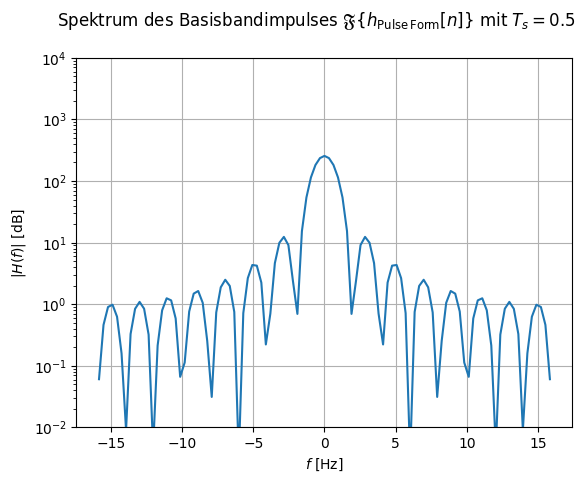

In [123]:
plt.plot(f, np.abs(baseband_spectrum)**2)
plt.suptitle(r"Spektrum des Basisbandimpulses $\mathfrak{F} \{ h_{\mathrm{Pulse\,Form}}[n] \}$ mit $T_s = $" + f"{T_s}")
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$|H(f)|$ [dB]')
plt.grid(True)
plt.yscale('log')
plt.ylim(10e-3, 10e3)

### Bilden Sie die Dirac-Summe der Modulationssymbole $ \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(t - i T_s\right) $

- Ziel: NumPy Array mit der Dirac-Summe
- Hinweis: Die Zeit $t$ ist diskret, wobei ein Indexbin $n$ einem Zeitpunkt $t = n \cdot T_{\text{Sample}}$ entspricht
    - Die Dauer eines Samples $T_{\text{sample}}$ ist gegeben durch: $T_{\text{sample}} = \frac{T_s}{\text{sps}}$
- Das bedeutet die einzelnen Dirac-Summanden brauchen einen zeitlichen Abstand von $T_{\text{s}}$,
was in Samples durch die Beziehung $T_{Sample} $  [ $ \frac{s}{Sample} $] $ =  \frac{T_s}{sps} \text{ } $[ $ \frac{s}{Sample} $] gegeben ist. Durch Umstellen ergibt sich der Abstand in Samples durch:

$$ \text{sps} = \frac{T_s}{T_{\text{Sample}}} \quad \text{, die Einheit beider Seiten ist nun Samples}$$

In Bins ausgedrückt ergibt sich die Dirac-Summe also zu:

$$
    x_{\text{I, no shape}}[n] = \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(n - i \text{ sps}\right) \quad \text{, mit } N = \text{len(BPSK)}\cdot sps
$$

#### Aufgabe:
- Erstellen Sie die Dirac-Summe `x_i_no_shape`
- Erstellen Sie zusätzlich die Zeitvariable `t`
- Hinweis: Der `signal.gausspulse` der Scipy Bibliothek kann für $\delta (t)$ verwendet werden


In [64]:
x_i_no_shape = np.zeros(len(BPSK) * sps)
t = np.arange(len(x_i_no_shape)) * T_sample
for n in range(len(BPSK)):
    x_i_no_shape += BPSK[n] * signal.gausspulse(t - n*T_s)

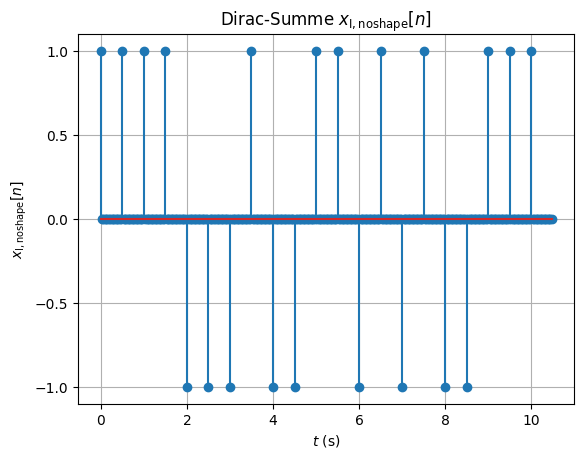

In [65]:
plt.stem(t, x_i_no_shape)
plt.grid(True)
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$x_{\rm{I, no shape}}[n]$')
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title(r"Dirac-Summe $x_{\rm{I, no shape}}[n]$")
plt.show()

## Pulsformung

Das Sendesignal wird nun mit der Basisbandpulse $h_{\tiny{\text{Pulse Form}}}[n]$ Form geformt. Die BPSK Modulationssamples für den I-Anteil werden $x_{\text{I, no shape}}[n] = \Re\left\{x_{\text{NF, no shape}}[n]\right\}$ (Dirac-Summe) werden also mit $h_{\tiny{\text{Pulse Form}}}[n]$ gefaltet:

$$
    x_{\text{I, shaped}}[n] = x_{\text{I, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n]
$$
Wird als Basisbandpuls ein Raised-Cosine verwendet, ergibt sich die Faltung zu:
$$
h_{\tiny{\text{Pulse Form}}}[n] = \text{sinc}\left(\frac{n}{T_s f_s}\right) \cdot \frac{\cos\left(\pi \beta \frac{n}{T_s f_s}\right)}{1 - \left(2 \beta \frac{n}{T_s f_s}\right)^2}
$$

where:
\begin{align*}
\text{sinc}(x) &= \frac{\sin(\pi x)}{\pi x} \\
T_s &= \text{symbol period} \\
\beta &= \text{roll-off factor} \\
f_s &= \text{sampling frequency}
\end{align*}

#### Aufgabe:

- Berechnung von $x_{\text{I, shaped}}[n]$ in `x_i_shaped`
- Erstellen Sie ein passenden Zeitvektor `t`
- Hinweise:
    - Nutzen Sie die Funktion `np.convolve` für die Faltung
    - Der Basisbandpuls $h_{\tiny{\text{Pulse Form}}}[n]$ ist bereits gegeben: `h_pulse_form`

In [67]:
x_i_shaped = np.convolve(x_i_no_shape, h_pulse_form)
t = np.arange(x_i_shaped.size) * T_sample

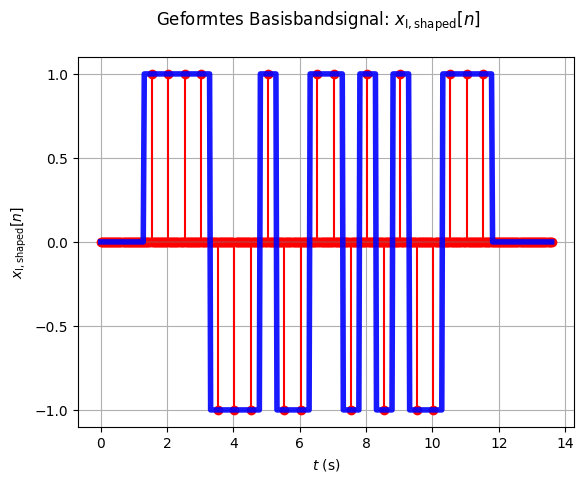

In [68]:
# convert the shape of the dirac sum to the shape of the convolution result
dirac_sum_zero_padded = np.zeros(len(x_i_shaped))
dirac_sum_zero_padded[h_pulse_form.size//2-1:h_pulse_form.size//2+len(x_i_no_shape)-1] = x_i_no_shape
plt.suptitle(r"Geformtes Basisbandsignal: $x_{\rm{I, shaped}}[n]$")
plt.stem(t, dirac_sum_zero_padded, 'r')
plt.plot(t, x_i_shaped, 'b', linewidth=4, alpha=0.9)
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.grid(True)
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$x_{\rm{I, shaped}}[n]$')
plt.show()

#### Spektrum des geformten Sendesignals $\mathfrak{F} \{x_{\text{I, shaped}}[n] \}$

#### Aufgabe:
- Berechnen Sie $\mathfrak{F} \{x_{\text{I, shaped}}[n] \}$ und speichern Sie das Ergebnis in `x_i_shaped_spectrum`
- Erstellen Sie in der korrekten Auflösung den zugehörigen Frequenzvektor `f`

In [125]:
x_i_shaped_spectrum = np.fft.fftshift(np.fft.fft(x_i_shaped))
f = np.fft.fftshift(np.fft.fftfreq(x_i_shaped.size, T_sample))

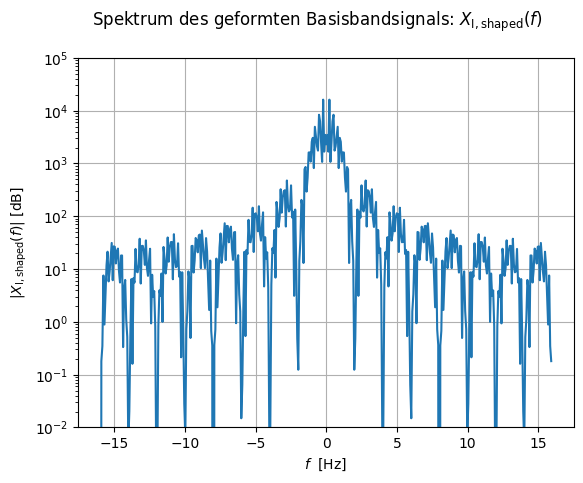

In [126]:
plt.plot(f, np.abs(x_i_shaped_spectrum)**2)
plt.suptitle(r"Spektrum des geformten Basisbandsignals: $X_{\rm{I, shaped}}(f)$")
plt.xlabel(r"$f$  [Hz]")
plt.ylabel(r"$|X_{\rm{I, shaped}}(f)|$ [dB]")
plt.grid(True)
plt.ylim(10e-3,10e4)
plt.yscale('log')

### Aufbau des Trägersignals

![IQ Sampling Receiver](./images/IQ_diagram_sender.png)

- Gemäß des Blockschaltbildes brauchen wir ein Carrier $s_c(t)$, welcher das Basisbandsignal auf eine Trägerfrequenz $f_c$ hochmischen kann
- Dieser wird direkt mit dem I-Anteil des Basisbandsignals $x_{\text{I, shaped}}(t)$ multipliziert
- Der I-Anteil wird laut obigen Berechnungen mit dem Cosinus übertragen. Blockschaltbild konform muss $s_c(t)$ für den I-Anteil also wie folgt aussehen:
$$
    s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Aus der $90°$ Phasendrehung folgt, dass $s_c(t)$ für den Q-Anteil wie folgt aussehen muss:
$$
    s_{\text{c,Q}}(t) = \cos(2 \pi f_c t + \frac{\pi}{2}) = \sin(2 \pi f_c t)
$$

#### Aufgabe:
- Generieren Sie zu $f_c = 2$ die Träger $s_{\text{c,I}}(t)$ in `s_c_I` und $s_{\text{c,Q}}(t)$ in `s_c_Q`
- Erstellen Sie einen passenden Zeitvektor `t`

In [76]:
t = np.arange(x_i_shaped.size) * T_sample
f_c = 2

s_c_I = np.cos(2*np.pi*f_c*t)
s_c_Q = np.cos(2*np.pi*f_c*t - np.pi/2)

([<matplotlib.axis.YTick at 0x150a5f050>,
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0')])

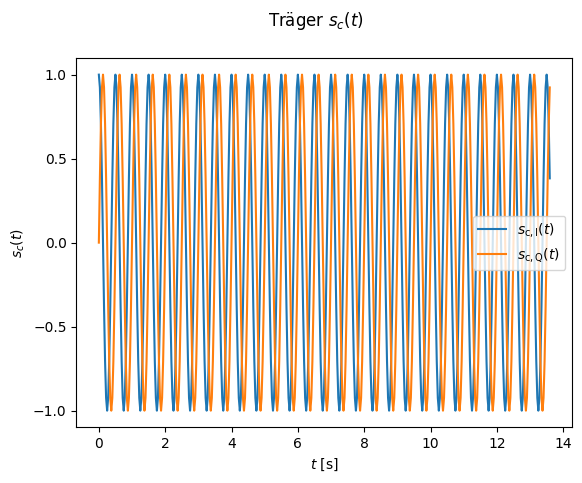

In [77]:
plt.plot(t, s_c_I)
plt.plot(t, s_c_Q)
plt.suptitle(r"Träger $s_c(t)$")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$s_c(t)$")
plt.legend([r"$s_{\rm{c,I}}(t) $", r"$s_{\rm{c,Q}}(t) $"])
plt.yticks([-1,-0.5,0,0.5,1])

### Hoschmischen des Basisbandsignals $x_{\text{I, shaped}}(t)$ auf die Trägerfrequenz $f_c$

- Hinweis: Es wurde von Beginn an BPSK verwendet. Die Symbole haben ausschließlich einen Realteil, daher ist der Q-Anteil des Basisbandsignals  $x_{\text{Q, shaped}}(t) = 0$. Es muss demnach also nur der I-Anteil hochgemischt werden $x_{\text{I, shaped}}(t)$:

Das Passbandsignal $s_{\text{HF}}(t)$ kann also wie folgt beschrieben werden:
$$
    s_{\text{HF}}(t) = I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t) = x_{\text{I, shaped}}(t) \cos(2 \pi f_{\text{c}} t) - 0 \cdot \sin(2 \pi f_{\text{c}} t)
$$

#### Aufgabe:
- Berechnen Sie $s_{\text{HF}}(t)$ in `s_hf`
- Erstellen Sie den passenden Zeitvektor `t`

In [78]:
s_hf = x_i_shaped * s_c_I - 0 * s_c_Q
t = np.arange(s_hf.size) * T_sample

Text(0.5, 0, '$t$ [s]')

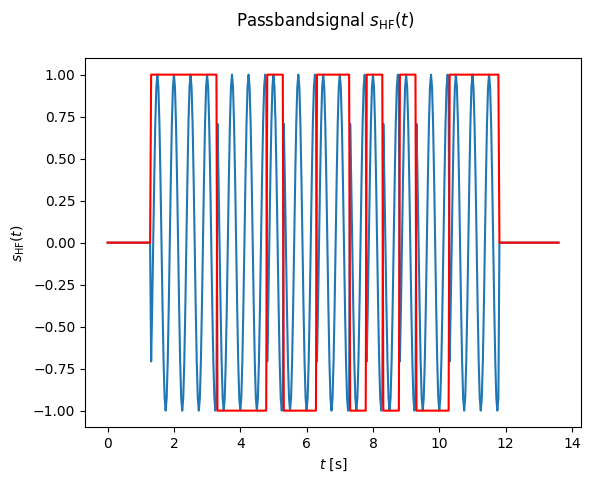

In [79]:
plt.plot(t, s_hf)
plt.plot(t, x_i_shaped, color='red')
plt.suptitle(r"Passbandsignal $s_{\rm{HF}}(t)$")
plt.ylabel(r"$s_{\rm{HF}}(t)$")
plt.xlabel(r"$t$ [s]")

#### Spektrum des Passbandsignals $\mathfrak{F} \{ s_{\tiny{\text{HF}}}(t) \}$

#### Aufgabe:
- Berechnen Sie $\mathfrak{F} \{ s_{\tiny{\text{HF}}}(t) \}$ in `s_hf_spectrum`
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`

In [80]:
s_hf_spectrum = np.fft.fftshift(np.fft.fft(s_hf))
f = np.fft.fftshift(np.fft.fftfreq(s_hf.size, T_sample))

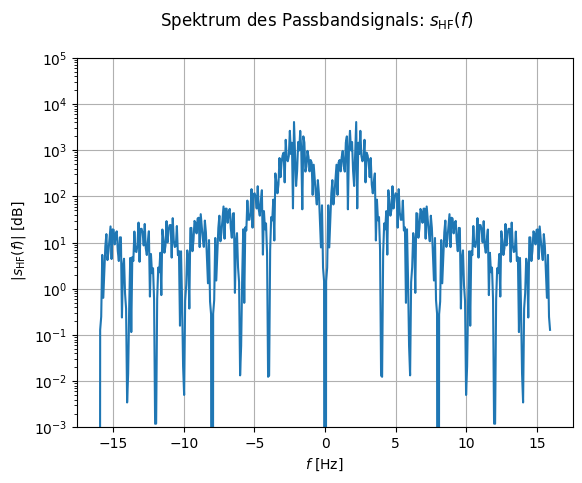

In [81]:
plt.suptitle(r"Spektrum des Passbandsignals: $s_{\rm{HF}}(f)$")
plt.plot(f, np.abs(s_hf_spectrum)**2)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r" $ | s_{\rm{HF}}(f) | $ [dB]")
plt.grid(True)
plt.yscale('log')
plt.ylim(10e-4, 10e4)
plt.show()

## Empfänger (Direct Downconversation)

Bei der _Direct Downconversation_, wird vom Empfangssignal im SDR der I und Q Teil separat extrahiert. Nur so kann das reale Empfangssignal wieder in die komplexe Basisbandsignalform zurückgeführt werden.

<div style="text-align: center;">
    <img src="./images/IQ_sampling_receiver.png" alt="IQ Sampling Receiver" width="400"/>
</div>

- Gemäß Blockschaltbild wird ein Trägersignal $s_{\text{c}}(t)$ benötigt. Dieses muss die gleiche Trägerfrequenz $f_c$ haben wie auch der Träger beim Sender
    - Für den I-Anteil wird wie beim Sender $s_{\text{c,I}}(t) = \cos(2 \pi f_c t)$ verwendet (oberer Teil im Blockschaltbild)
    - Für den Q-Anteil wird eine Phasendrehung von $\Phi = \frac{\pi}{2}$ auf $ s_{\text{c,I}}(t) $ angewendet: $s_{\text{c,Q}}(t) = \cos(2 \pi f_c t + \frac{\pi}{2}) = \sin(2 \pi f_c t)$
- Wichtig: Die Schritte Heruntermischen und Filtern finden bis zur ADC kontinuierlich statt
- Bei der ADC wird das Signal mit der Sampling Rate $f_s$ *diskretisiert* und die reellen Samples *quantisiert*




## Extraktion des I-Anteils (oberer Teil im Blockschaltbild):

Das Heruntermischen von $ s_{\text{HF}}(t) $ mit dem Träger für den I-Anteil $s_{\text{c,I}}(t)$ lässt sich wie folgt beschreiben:

\begin{align*}
    \hat{I}_{\text{No Filter}}(t) &= s_{\text{HF}}(t) s_{\text{c,I}}(t) \\
    &= s_{\text{HF}}(t) \cos(2\pi f_{\text{c}} t) \\
    &= \frac{1}{2} I(t) \cos(4\pi f_{\text{c}} t) + \frac{1}{2} Q(t) I(t) \sin(4\pi f_{\text{c}} t) + \frac{1}{2} I(t)
\end{align*}
Ziel: Hochfrequente Anteile entfernen, sodass $\frac{1}{2} I(t)$ übrig bleibt.

Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter $h_{\tiny{\text{TP}}}(t)$ eliminiert:

\begin{align*}
    \hat{I}_{\text{Filtered}}(t) &= \hat{I}_{\text{No Filter}}(t) * h_{\tiny{\text{TP}}}(t) \\
    &= \mathfrak{F^{-1}} \{ \hat{I}_{\text{No Filter}}(f) \cdot H_{\tiny{\text{TP}}}(f) \} \\
    &\approx x_{\text{I, shaped}}(t) \approx x_{\text{I, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t)
\end{align*}

Der I-Anteil des Basisbandsignals $\hat{I}[n]$ wird dann durch eine ADC (Diskretisierung & Quantisierung) des Signals gewonnen:
\begin{align*}
    \hat{I}_{\text{Filtered}}(t) &\approx x_{\text{I, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t) \\
    \hat{I}[n] &= x_{\text{I, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n] \text{, } \quad t= \frac{n}{f_s}
\end{align*}

## Extraktion des Q-Anteils (unterer Teil im Blockschaltbild):
\begin{align*}
    \hat{Q}_{\text{No Filter}}(t) &= s_{\text{HF}}(t) s_{\text{c,Q}}(t) \\
    &= s_{\text{HF}}(t) \sin(2\pi f_{\text{c}} t) \\
    &= \frac{1}{2} I(t) Q(t) \sin(4\pi f_{\text{c}} t) - \frac{1}{2} Q(t) \cos(4\pi f_{\text{c}} t) + \frac{1}{2} Q(t)
\end{align*}

Ziel: Hochfrequente Anteile entfernen, sodass $\frac{1}{2} Q(t)$ übrig bleibt.

Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter $h_{\tiny{\text{TP}}}(t)$ eliminiert:

\begin{align*}
    \hat{Q}_{\text{Filtered}}(t) &= \hat{Q}_{\text{No Filter}}(t) * h_{\tiny{\text{TP}}}(t) \\
    &= \mathfrak{F^{-1}} \{ \hat{Q}_{\text{No Filter}}(f) \cdot H_{\tiny{\text{TP}}}(f) \} \\
    &\approx x_{\text{Q, shaped}}(t) \approx x_{\text{Q, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t)
\end{align*}

Der Q-Anteil des Basisbandsignals $\hat{Q}[n]$ wird dann durch eine ADC (Diskretisierung & Quantisierung) des Signals gewonnen:
\begin{align*}
    \hat{Q}_{\text{Filtered}}(t) &\approx x_{\text{Q, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t) \\
    \hat{Q}[n] &= x_{\text{Q, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n] \text{, } \quad t= \frac{n}{f_s}
\end{align*}

## Ende: Bildung des NumPy Arrays, welches die SDR _uhd_ Bibliothek bereitstellt

Am Ende werden vom SDR die I und Q Komponenten wieder zu einem komplexen Signal zusammengefügt, dass im NumPy Array dann der Realteil eines Samples dessen I Sample enthält und der Imaginärteil dessen zugehörigen Q Sample enthält.

Ein Sample am Index $n$ eines NumPy Arrays $\text{Array}[n]$ enthält also die I- und Q-Komponente des $n$-ten Symbols:

$$
    \text{Array}[n] = I[n] + j \text{ } Q[n]
$$



## Diese Schritte werden nachfolgend einmal durchgeführt.





## 1. Heruntermischen des Signals in zurück in das Basisband

- Es wurde BPSK verwendet, daher ist der Q-Anteil Null. $\hat{Q}_{\tiny{\text{No Filter}}}$ muss also nicht berechnet werden womit der untere Teil des obigen Empfänger Blockschaltbildes hier nicht berechnet werden muss.
- Der obere Teil des Empfänger Blockschaltbildes führt zum Erhalt des I-Anteils, welcher die BPSK Symbole trägt.

#### Aufgabe:
- Berechnen Sie $\hat{I}_{\tiny{\text{No Filter}}}(t)$ in `I_hat_i_no_filter`, um das heruntergemischte Signal zu erhalten
$$
     \hat{I}_{\tiny{\text{No Filter}}}(t) = s_{\tiny{\text{HF}}}(t)  s_{\text{c,I}}(t) \text{,} \quad \text{ mit } s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Erstellen Sie in passender Auflösung den zugehörigen Zeitvektor `t`


In [82]:
I_hat_i_no_filter = s_hf * s_c_I
t = np.arange(I_hat_i_no_filter.size) * T_sample

([<matplotlib.axis.YTick at 0x147979410>,
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0')])

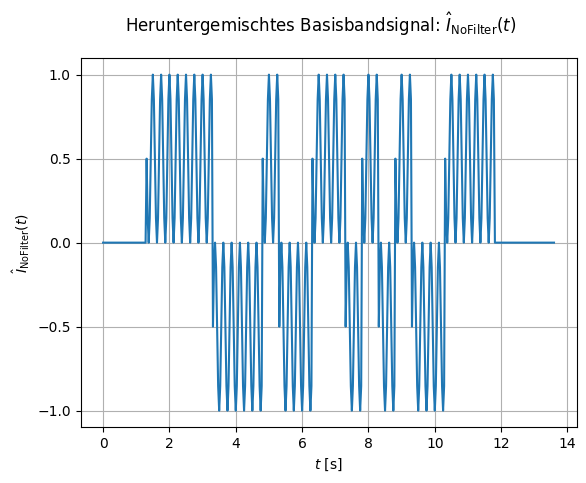

In [83]:
plt.plot(t, I_hat_i_no_filter)
plt.suptitle(r"Heruntergemischtes Basisbandsignal: $\hat{I}_{\rm{No Filter}}(t)$")
plt.xlabel(r"$t$ [s]")
plt.ylabel(r"$\hat{I}_{\rm{No Filter}}(t)$")
plt.grid(True)
plt.yticks([-1,-0.5,0,0.5,1])

### Spektrum des heruntergemischten Empfangssignals $\mathfrak{F} \{ \hat{I}_{\tiny{\text{No Filter}}}(t)  \}$

#### Aufgabe:
- Berechnen Sie $\hat{I}_{\tiny{\text{No Filter}}}(f) $ in `I_hat_i_no_filter_spectrum`, um das Spektrum des Signals zu erhalten
$$
     \hat{I}_{\tiny{\text{No Filter}}}(f)  = \mathfrak{F} \{ \hat{I}_{\tiny{\text{No Filter}}}(t)  \}
$$
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`

In [84]:
I_hat_i_no_filter_spectrum = np.fft.fftshift(np.fft.fft(I_hat_i_no_filter))
f = np.fft.fftshift(np.fft.fftfreq(len(I_hat_i_no_filter), T_sample))

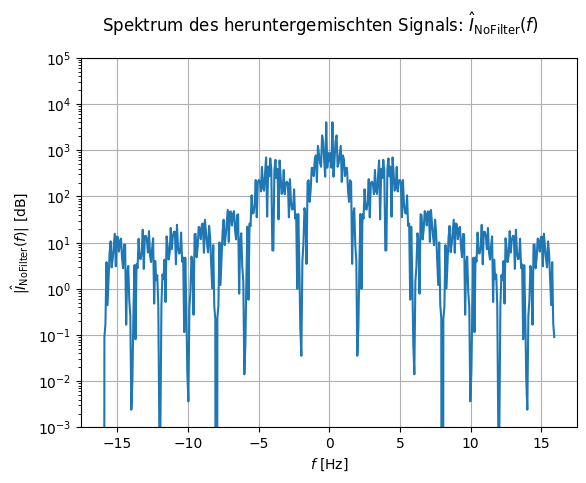

In [128]:
plt.plot(f, np.abs(I_hat_i_no_filter_spectrum)**2)
plt.suptitle(r"Spektrum des heruntergemischten Signals: $\hat{I}_{\rm{No Filter}}(f)$")
plt.grid(True)
plt.yscale('log')
plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"|$\hat{I}_{\rm{No Filter}}(f)$| [dB]")
plt.ylim(10e-4, 10e4)
plt.show()

### 2. Tiefpassfilterung zur Berechnung von $\hat{I}_{\text{Filtered}}(t)$

**Gegeben:**
- Frequenzarray `f` (enthält Frequenzwerte in Hz)
- Grafische Darstellung des Spektrums mit Frequenzachse in Hz

**Problemstellung:**
1. **Entfernung hochfrequenter Anteile** bei $-2f_c$ und $2f_c$
2. Bestimmung der **Abschneidefrequenz** $f_k$ (kritische Frequenz in Hz):
   - Direkt ablesbar aus der Spektrumsdarstellung
   - Alternativ rechnerisch bestimmbar
3. **Umsetzung in Python**:
   - Nullsetzen aller Array-Werte außerhalb des gewünschten Spektrums
   - Erfordert präzise Zuordnung von Frequenzwerten (Hz) zu Array-Indizes

#### Aufgabe: Frequenz-zu-Index-Mapping
Implementierung einer Funktion `convert_f_Hz_to_index`, die:
- Eingabe: Einzelwert `f_Hz` (Ziel-Frequenz in Hz)
- Eingabe: Frequenzarray `f` (NumPy-Array)
- Ausgabe: Index $k$ desjenigen Array-Elements, das **am nächsten** an `f_Hz` liegt


In [88]:
def convert_f_Hz_to_index(f_Hz: float, f: np.ndarray) -> int:
    """
    Findet den Index der Frequenz in einem Array `f`, die am nächsten zum Zielwert `f_Hz` liegt.

    Diese Funktion berechnet den elementweisen absoluten Unterschied zwischen dem Frequenzarray `f`
    und der Ziel-Frequenz `f_Hz` und gibt den Index des minimalen Unterschieds zurück.

    Parameter:
        f_Hz (float): Ziel-Frequenz in Hertz, für die der nächstgelegene Index gesucht wird.
        f (np.ndarray): 1D-Array von Frequenzwerten in Hertz, typischerweise aus einer FFT- oder
                        Frequenzanalyse generiert.

    Rückgabe:
        int: Index des Werts in `f`, der `f_Hz` am nächsten liegt. Bei mehreren gleichen Minima wird
             der erste auftretende Index zurückgegeben.

    Beispiele:
        >>> f = np.array([0, 100, 200, 300, 400])  # Frequenzarray in Hz
        >>> convert_f_Hz_to_index(250, f)
        2  # da 200 näher an 250 liegt als 300
        >>> convert_f_Hz_to_index(300, f)
        3  # exakte Übereinstimmung

    Anwendungskontext:
        - Nützlich zur Identifikation von Frequenzbändern in Fourier-Transformationen (FFT)
        - Mapping von physikalischen Frequenzen auf diskrete Frequenz-Indizes in Spektralanalysen
    """
    return np.argmin(np.abs(f - f_Hz))


### Design eines Filters

Ziel: Das Spektrum des heruntergemischten Signals $\mathfrak{F}\{\hat{I}_{\text{NoFilter}}(t)\}$ soll durch Entfernen der Störungen bei $\pm 2f_c$ so bereinigt werden, dass im Idealfall die Hauptkomponenten des ursprüngliche Sendesignal-Spektrum $\mathfrak{F}\{x_{\text{I, shaped}}(t)\}$ (vor der Hochmischung) übrig bleiben.

$$
    \hat{I}_{\text{NoFilter}}(t) = \frac{1}{2} I(t) \cos(4\pi f_{\text{c}} t) + \frac{1}{2} Q(t) I(t) \sin(4\pi f_{\text{c}} t) + \frac{1}{2} I(t)
$$

#### Aufgabe:
- Designen Sie ein solches Filter $H_{\tiny{\text{TP}}}(f)$ in `H_tp`, welches das Ziel erreichen kann (Hinweis: Ein Rechteck Signal $\text{rect}(f)$ könnte ein solches Verhalten erzielen)
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`
- Verwenden Sie dabei die oben implementierte Funktion `convert_f_Hz_to_index`, welche `f_Hz` auf dessen Frequenzindex $k$ abbildet.
- Vergessen Sie nicht mit dem Filter gleichzeitig den Faktor $\frac{1}{2}$ im letzten Summanden aus $\hat{I}_{\text{NoFilter}}(t)$ `I_hat_i_no_filter` zu korrigieren.

In [89]:
f = np.fft.fftshift(np.fft.fftfreq(len(I_hat_i_no_filter), T_sample))

H_tp = np.zeros(len(f))
# correct the 1/2 factor from downconversion

# TODO: Calculate the Nyquist frequency and set the cutoff frequency to 1/4 of the Nyquist frequency
border = 1/T_s
# index from f at border
left_index = convert_f_Hz_to_index(-border, f)
rigth_index = convert_f_Hz_to_index(border, f) + 1
H_tp[left_index:rigth_index] = 1
H_tp = H_tp * 2

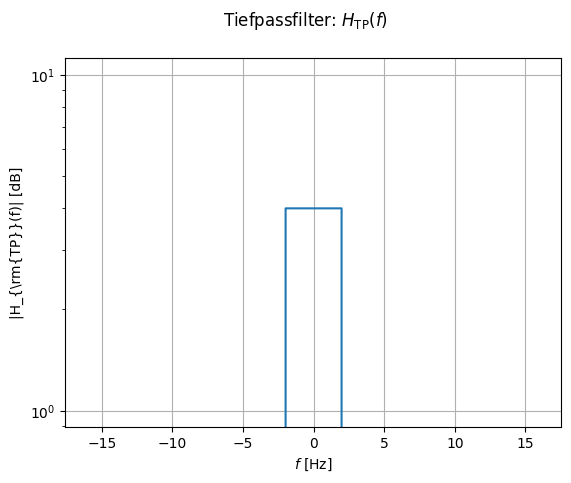

In [90]:
plt.suptitle(r"Tiefpassfilter: $H_{\rm{TP}}(f)$")
plt.plot(f, np.abs(H_tp)**2)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"|H_{\rm{TP}}(f)| [dB]")
plt.yscale('log')
plt.grid(True)

#### Aufgabe:
- Wenden Sie $H_{\tiny{\text{TP}}}(f)$ auf $\hat{I}_{\text{NoFilter}}(f)$ und legen Sie das Ergebnis in `I_hat_i_filtered_spectrum` ab:
$$
    \hat{I}_{\text{Filtered}}(f) = \hat{I}_{\text{NoFilter}}(f) \cdot H_{\tiny{\text{TP}}}(f)
$$
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`


In [91]:
I_hat_i_filtered_spectrum = I_hat_i_no_filter_spectrum * H_tp
f = np.fft.fftshift(np.fft.fftfreq(I_hat_i_filtered_spectrum.size, T_sample))

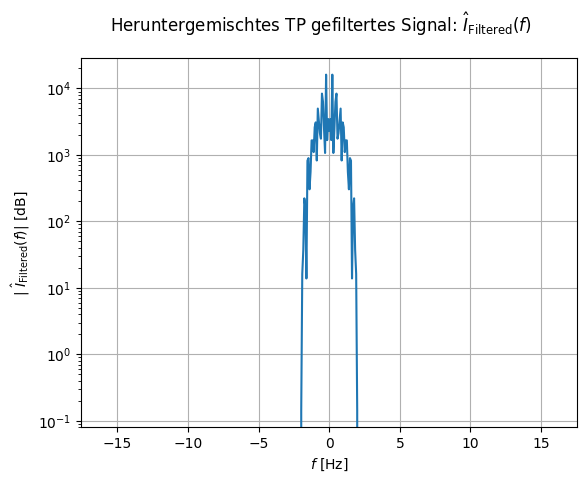

In [92]:
plt.suptitle(r"Heruntergemischtes TP gefiltertes Signal: $\hat{I}_{\rm{Filtered}}(f)$")
plt.plot(f, np.abs(I_hat_i_filtered_spectrum)**2)
plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"| $\hat{I}_{\rm{Filtered}}(f) | $ [dB]")
plt.grid(True)
plt.yscale('log')


#### Aufgabe:
- Transformieren Sie nun $\hat{I}_{\text{Filtered}}(f)$ wieder in den Zeitbereich in `I_hat_i_filtered`
- Erstellen Sie dazu einen passenden Zeitvektor `t`

In [93]:
I_hat_i_filtered = np.fft.ifft(np.fft.fftshift(I_hat_i_filtered_spectrum))
t = np.arange(I_hat_i_filtered.size) * T_sample

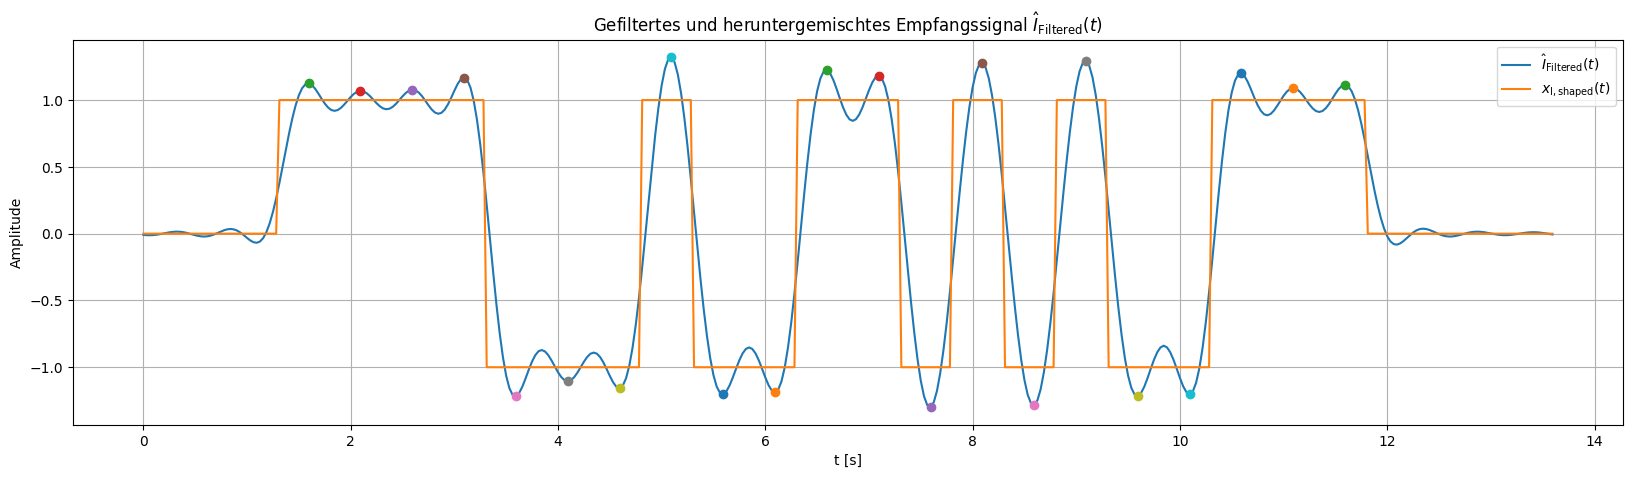

In [105]:
plt.figure(figsize=(20, 5))
plt.plot(t, I_hat_i_filtered.real)
plt.plot(t, x_i_shaped)
plt.grid(True)
plt.legend([r'$\hat{I}_{\rm{Filtered}}(t)$', r'$x_{\rm{I,shaped}}(t)$'])

# Berechnung der Abtastzeitpunkte
sample_times = (np.arange(len(I_hat_i_filtered))  + (num_taps // 2)) * T_sample

start = num_taps // 2 + 1
end = I_hat_i_filtered.size - num_taps // 2
sample_times = np.arange(bits.size)
n = start

while n <= end:
    plt.plot(t[n], I_hat_i_filtered[n], 'o')
    n += sps

plt.xlabel(r't [s]')
plt.ylabel('Amplitude')
plt.title(r'Gefiltertes und heruntergemischtes Empfangssignal: $\hat{I}_{\rm{Filtered}}(t)$')
plt.show()



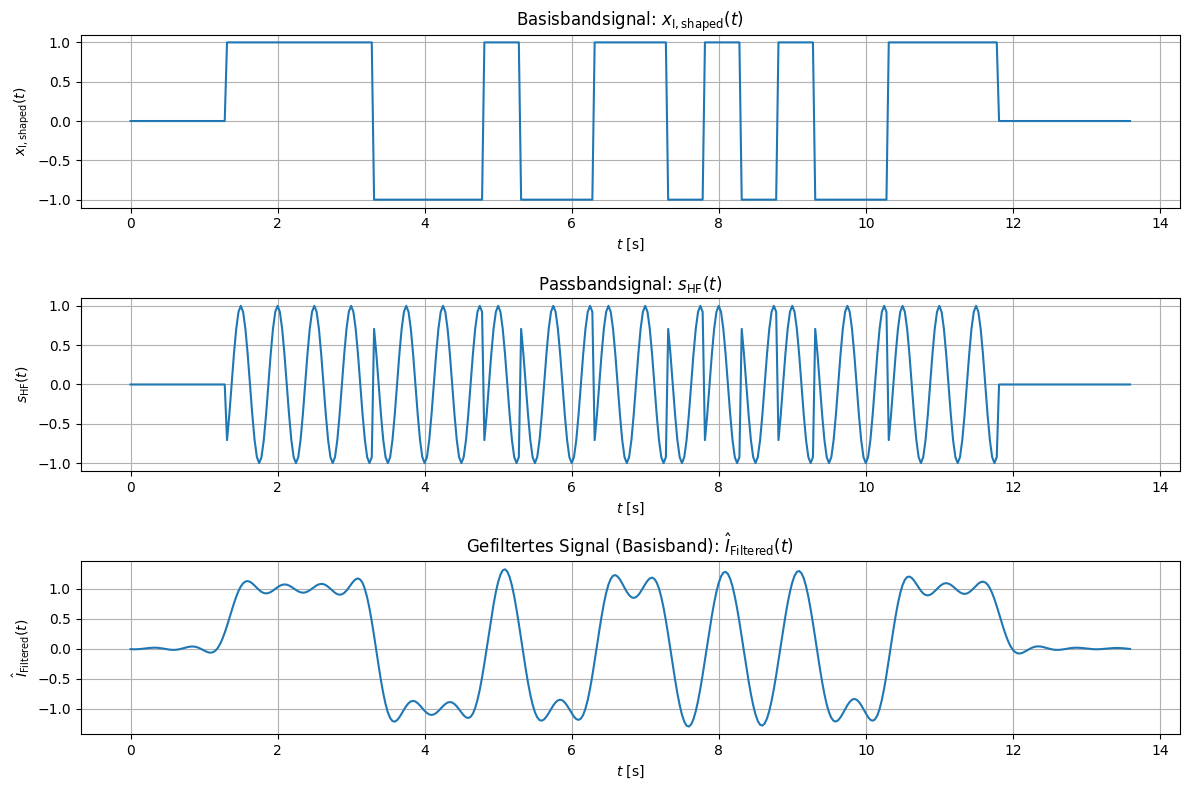

In [129]:
# TODO: Konsistente Farben dafür verwenden 1 Farbe für alles was das SDR macht und eine Farbe die man selbst der API übergibt

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t, x_i_shaped)
plt.title(r"Basisbandsignal: $x_{\rm{I, shaped}}(t)$")
plt.xlabel(r'$t$ [s]')
plt.ylabel(r"$x_{\rm{I, shaped}}(t)$")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, s_hf)
plt.title(r"Passbandsignal: $s_{\rm{HF}}(t)$")
plt.xlabel(r'$t$ [s]')
plt.ylabel(r"$s_{\rm{HF}}(t)$")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, I_hat_i_filtered)
plt.title(r"Gefiltertes Signal (Basisband): $\hat{I}_{\rm{Filtered}}(t)$")
plt.xlabel(r'$t$ [s]')
plt.ylabel(r"$\hat{I}_{\rm{Filtered}}(t)$")
plt.grid(True)

plt.tight_layout()
plt.show()

# Frage: Woher kommen wenn ein Rechteck als Basisbandpulsform verwendet wird unten nach der Tiefpassfilterung die Überschwinger?
- Ein Rechteck hat eine unendliche Bandbreite
- Bei der Tiefpassfilterung werden die hohen Frequenzen abgeschnitten
- Die Überschwinger kommen also daher, dass die hohen Frequenzen abgeschnitten werden und somit im Zeitbereich Überschwinger entstehen

(0.0001, 10000.0)

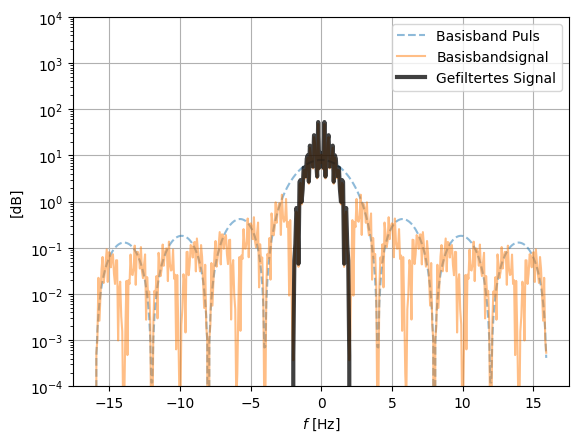

In [136]:
f = np.fft.fftshift(np.fft.fftfreq(I_hat_i_filtered.size, T_sample))

# Hier anpassen, je nachdem welcher Basisbandpuls verwendet wird (Rechteck oder Raised Cosine)
base_band_pulse = get_rect_pulse(num_taps=len(I_hat_i_filtered))

I_hat_i_filtered_normalized = normalize_energy(I_hat_i_filtered)
x_i_shaped_normalized       = normalize_energy(x_i_shaped)
baseband_signal_normalized  = normalize_energy(base_band_pulse)

plt.plot(f, np.abs(np.fft.fftshift(np.abs(np.fft.fft(baseband_signal_normalized  ))**2)), alpha=0.5, linestyle='--')
plt.plot(f, np.abs(np.fft.fftshift(np.abs(np.fft.fft(x_i_shaped_normalized       ))**2)), alpha=0.5, linestyle='-')
plt.plot(f, np.abs(np.fft.fftshift(np.abs(np.fft.fft(I_hat_i_filtered_normalized ))**2)), color='black', linewidth=3, alpha=0.75)

plt.legend(["Basisband Puls", "Basisbandsignal", "Gefiltertes Signal"])
plt.xlabel(r"$f$ [Hz]")
plt.ylabel("[dB]")
plt.grid(True)
plt.yscale('log')
plt.ylim(10e-5,10e3)

## 3. ADC von $\hat{I}_{\tiny{\text{Filtered}}}(t)$

#### Aufgabe:
- Führen sie das Sampling für $\hat{I}_{\tiny{\text{Filtered}}}(t)$, welches in `I_hat_i_filtered` gespeichert ist aus (Hinweis: $f_s = \text{sps}$)
- Speichern Sie den Realteil der Samples in `rx_sampled`
- Konvertieren Sie `rx_sampled` in ein NumPy Array `sdr_iq_samples` vom Typ `np.complex64`
- Dies ist das Ergebnis, welches Ihnen die uhd Bibliothek nach einer Messung bereitstellt

In [112]:
fs = sps

# Das ist nun der I Teil des empfangenen Signals
rx_sampled = I_hat_i_filtered[::fs].real

# Das SDR liefert nun daraus ein NumpPy Array mit dem dtype complex64
rx_sampled = rx_sampled.astype(np.complex64)


In [113]:
print(rx_sampled)

[-0.00920983+0.j -0.01162895+0.j -0.03190535+0.j  1.0352672 +0.j
  1.0228562 +0.j  1.0278616 +0.j  1.0696876 +0.j -1.0630221 +0.j
 -1.0371886 +0.j -1.0650165 +0.j  1.1094767 +0.j -1.0594388 +0.j
 -1.0762444 +0.j  1.0661356 +0.j  1.0731068 +0.j -1.1015066 +0.j
  1.0956227 +0.j -1.096081  +0.j  1.1013747 +0.j -1.0635504 +0.j
 -1.08041   +0.j  1.0576416 +0.j  1.0324348 +0.j  1.0475646 +0.j
 -0.01961131+0.j -0.00376352+0.j  0.00133488+0.j  0.0055133 +0.j]


In [114]:
rx_sampled


array([-0.00920983+0.j, -0.01162895+0.j, -0.03190535+0.j,  1.0352672 +0.j,
        1.0228562 +0.j,  1.0278616 +0.j,  1.0696876 +0.j, -1.0630221 +0.j,
       -1.0371886 +0.j, -1.0650165 +0.j,  1.1094767 +0.j, -1.0594388 +0.j,
       -1.0762444 +0.j,  1.0661356 +0.j,  1.0731068 +0.j, -1.1015066 +0.j,
        1.0956227 +0.j, -1.096081  +0.j,  1.1013747 +0.j, -1.0635504 +0.j,
       -1.08041   +0.j,  1.0576416 +0.j,  1.0324348 +0.j,  1.0475646 +0.j,
       -0.01961131+0.j, -0.00376352+0.j,  0.00133488+0.j,  0.0055133 +0.j],
      dtype=complex64)

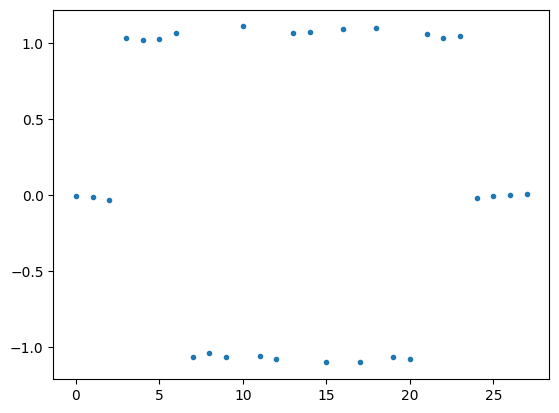

In [115]:
plt.plot(rx_sampled, '.')

# Ende des Notebooks, Nachfolgender Teil kommt in die Synchronisation

# Am ende den SDR Teil überspringen
# SDR Box mit farben verwenden die wieder zeigt was das sdr macht und was das eigene Signal ist

# Nächstes Notebook: SIGMF Reader Vorbereiten, notebook vorbereiten, wie bursts übertragen werden
Ziel SiGMF FIles erzeugen, einlesen

1. Sigmf Schreiben (Burst Dauer, CFO, Fc etc einstellen)
2. Sigmf lesen und auf API Schnittstelle zum sendn bringen
3. Ziel für Praxisphase: man kann sigmf files breitstellen
4. Dann Synchronisation

/var/folders/89/fxr0x5lx46z0k6v48n7hxp6c0000gn/T/ipykernel_19000/4165057121.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  corr[i] = np.dot(rx_sampled[i:i+len(synchronization_sequence)], synchronization_sequence)


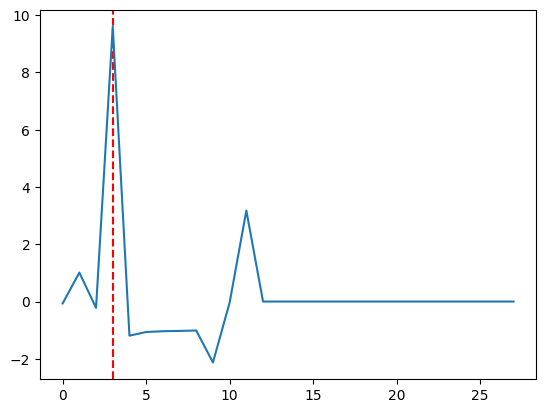

In [116]:
corr = np.zeros(len(rx_sampled))

for i in range(len(rx_sampled) - len(synchronization_sequence)):
    corr[i] = np.dot(rx_sampled[i:i+len(synchronization_sequence)], synchronization_sequence)

tau0 = np.argmax(np.abs(corr))
plt.axvline(tau0, color='r', linestyle='--')
plt.plot(corr)

In [117]:
print(f"tau0: {tau0}")
print(f"rx len: {len(rx_sampled)}")


tau0: 3
rx len: 28


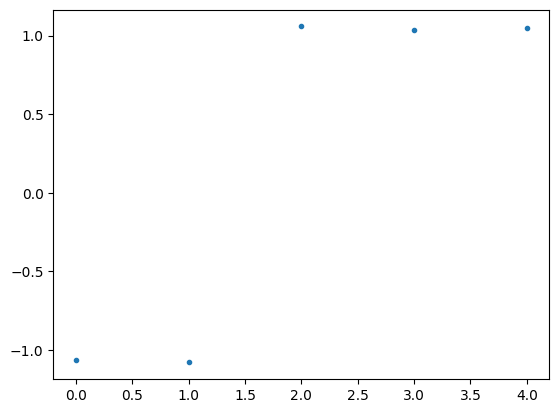

In [118]:
# data bits start at tau0 + len(syncronisation_sequence) and end at tau0 + len(syncronisation_sequence) + len(data_bits)
data_symbols_received = rx_sampled[tau0+len(synchronization_sequence):tau0 + len(synchronization_sequence) + len(data_bits)]
plt.plot(data_symbols_received, '.')

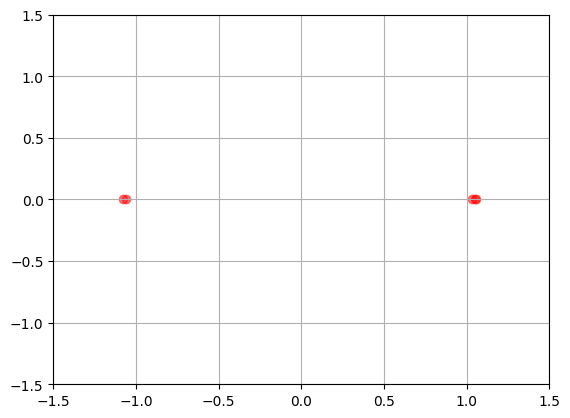

In [119]:
# iq plot
plt.scatter(np.real(data_symbols_received), np.imag(data_symbols_received), alpha=0.5, color='red')
plt.ylim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)
plt.grid(True)


In [120]:
# decision making
data_bits_received = np.zeros_like(data_bits)
for i, symbol in enumerate(data_symbols_received):
    if symbol.real > 0:
        data_bits_received[i] = 1
    else:
        data_bits_received[i] = 0

print("bits^hat = ", data_bits_received)
print("bits     = ", data_bits)

bits^hat =  [0 0 1 1 1]
bits     =  [0 0 1 1 1]
